In [3]:
from sklearn.mixture import GMM
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.metrics import accuracy_score
import itertools
from scipy import linalg
%matplotlib inline

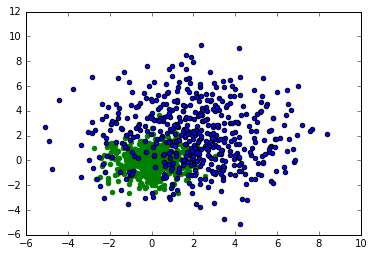

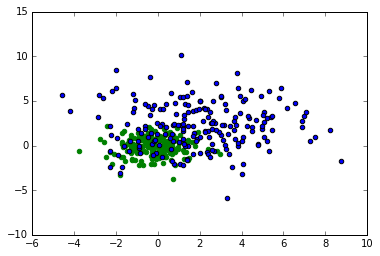

In [4]:
v = 2

middle_f = (0,0)
cov_matrix_f = np.array(([v / 2, 0 ], [0, v/2]))
firstSet =  np.random.multivariate_normal(middle_f, cov_matrix_f, 500)
firstSetTest =  np.random.multivariate_normal(middle_f, cov_matrix_f, 200)


middle_s = (v, v)
cov_matrix_s = np.array(([3*v, 0 ], [0, 3*v]))
secondSet = np.random.multivariate_normal(middle_s, cov_matrix_s, 500)
secondSetTest = np.random.multivariate_normal(middle_s, cov_matrix_s, 200)

plt.scatter(firstSet[:, 0],  firstSet[:, 1],color = 'green')
plt.scatter(secondSet[:, 0],  secondSet[:, 1])
plt.show()

x_train = np.concatenate((firstSet, secondSet))
y_train = np.concatenate([np.zeros((500)), np.ones((500))]).astype('int')

x_test = np.concatenate( [ firstSetTest, secondSetTest] )
y_test = np.concatenate([np.zeros((200)), np.ones((200))]).astype('int')

plt.scatter(firstSetTest[:, 0],  firstSetTest[:, 1],color = 'green')
plt.scatter(secondSetTest[:, 0],  secondSetTest[:, 1])
plt.show()

In [5]:
covar_type = 'diag'

for i in range(1,5):
    g1 =  GMM(n_components = i, covariance_type=covar_type, init_params='wmc', n_iter=20)
    g1.fit(firstSet)
    g2 =  GMM(n_components = i, covariance_type=covar_type, init_params='wmc', n_iter=20)
    g2.fit(secondSet)

    prediction  = np.array(np.log(firstSet.shape[0])+ g1.score(x_test)  < np.log(secondSet.shape[0])+g2.score(x_test)).astype('int')

    accuracy = np.mean(prediction == y_test) * 100
    print accuracy

86.0
86.25
85.5
86.5


In [6]:
#plot
"""

color_iter = itertools.cycle(['r', 'g', 'm', 'b', 'r'])
splot = plt.subplot(2, 1, 1)
for i, (mean, covar, color) in enumerate(zip(
        g1.means_, g1._get_covars(), color_iter)):
    
    v, w = linalg.eigh(covar)
    u = w[0] / linalg.norm(w[0])

    if not np.any(prediction == i):
            continue
        
    plt.scatter(x_test[prediction == i, 0], x_test[prediction == i, 1], .8, color=color)

    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi 
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.show()
"""
print 

# UBM - model. Correct

In [28]:
def computeMAP(firstSet,secondSet, x_test, y_test ):    
    accuracyVector = []
    
    nIter = 25
    ubm_model_first = mixture.GMM(n_components=2, covariance_type='diag', n_iter=1)
    ubm_model_first.fit(firstSet)
    
    ubm_model_second = mixture.GMM(n_components=2, covariance_type='diag', n_iter=1)
    ubm_model_second.fit(secondSet)
    
    prediction  = np.array(np.log(firstSet.shape[0])+ g1.score(x_test)  < np.log(secondSet.shape[0])+g2.score(x_test)).astype('int')

    accuracy = np.mean(prediction == y_test) * 100

    for i in range(1,nIter):
    ################################################################        
        
        #___________________________________________________
        # Here we copy initialisation values start model for
        # next changing covariance matrix
        initialmeans_first = ubm_model_first.means_
        #___________________________________________________
        
        
        adapted_gmm_first = mixture.GMM(n_components=2, covariance_type='diag', n_iter=1)
        adapted_gmm_first.means_ = ubm_model_first.means_
        adapted_gmm_first.covars_ = ubm_model_first.covars_
        adapted_gmm_first.weights_ = ubm_model_first.weights_
 
        # Make one EM-step
        adapted_gmm_first.fit(firstSet)
        # And change param's
        """
        ubm_means: means of the ubm <number array>
        ubm_covars: covariances of the ubm <number array> 
        ubm_weights: weights of the ubm <number array>
        new_means: means adapted from the ubm <number array>
        new_weights: weights adapted from the ubm <number array>
        T: scaling factor, number of samples
        relevance_factor: factor for scaling the adapted means 
        """    
        
        relevance_factor = 160
        scaleparam = 1
        T = firstSet.shape[0]
        n_i_first = adapted_gmm_first.weights_ * T
        
        alpha_i_first = n_i_first/(n_i_first + relevance_factor)
        
        # compute new weights
        adapted_gmm_first.weights_[ np.isnan(adapted_gmm_first.weights_)] = 0.0
        return_weights_first = ((alpha_i_first* adapted_gmm_first.weights_ / T) + (1-alpha_i_first)* \
                                ubm_model_first.weights_) * scaleparam
        ubm_model_first.means_ = return_weights_first
        
        #compute new means
        adapted_gmm_first.means_[ np.isnan(adapted_gmm_first.means_)] = 0.0
        return_means_first = alpha_i_first*adapted_gmm_first.means_+(1-alpha_i_first)*(ubm_model_first.means_)   
        ubm_model_first.means_ = return_means_first
        
        #compute new variance
        adapted_gmm_first.covars_[ np.isnan(adapted_gmm_first.covars_)] = 0.0
        return_covars_first = alpha_i_first*adapted_gmm_first.covars_ + (1-alpha_i_first)* \
                             (ubm_model_first.covars_ + np.dot(ubm_model_first.means_,ubm_model_first.means_))- \
                             np.dot(initialmeans_first,initialmeans_first)
        
    ##################################################################

        #___________________________________________________
        # Here we copy initialisation values start model to
        # further changing covariance matrix
        initialmeans_second = ubm_model_second.means_
        #___________________________________________________
        
        
        adapted_gmm_second = mixture.GMM(n_components=2, covariance_type='diag', n_iter=1)
        adapted_gmm_second.means_ = ubm_model_second.means_
        adapted_gmm_second.covars_ = ubm_model_second.covars_
        adapted_gmm_second.weights_ = ubm_model_second.weights_
        adapted_gmm_second.fit(secondSet)
        
        relevance_factor = 160
        T = secondSet.shape[0]
        n_i_second = adapted_gmm_second.weights_ * T
        alpha_i_second = n_i_second/(n_i_second + relevance_factor)
        
        # compute new weights
        return_weights_second = ((alpha_i_second* adapted_gmm_second.weights_ / T) + (1-alpha_i_second)*\
                                ubm_model_second.weights_) * scaleparam
        ubm_model_second.means_ = return_weights_second
        
        #compute new means
        adapted_gmm_second.means_[ np.isnan(adapted_gmm_second.means_)] = 0.0
        return_means_second = alpha_i_second*adapted_gmm_second.means_+(1-alpha_i_second)*(ubm_model_second.means_)    
        ubm_model_second.means_ = return_means_second
        
        
        #compute new variance
        adapted_gmm_second.covars_[ np.isnan(adapted_gmm_second.covars_)] = 0.0
        return_covars_second = alpha_i_second*adapted_gmm_second.covars_ + (1-alpha_i_second)*\
                        (ubm_model_second.covars_ + np.dot(ubm_model_second.means_,ubm_model_second.means_))-\
                        np.dot(initialmeans_second,initialmeans_second)
                
        #prediction
        prediction  = np.array(np.log(firstSet.shape[0])+ ubm_model_first.score(x_test)  < np.log(secondSet.shape[0])+ubm_model_second.score(x_test)).astype('int')

        accuracy = np.mean(prediction == y_test) * 100

        accuracyVector.append(accuracy)
    
    return accuracyVector

In [31]:
result = computeMAP(firstSet,secondSet, x_test, y_test )
print np.max(result)

86.75
